In [ ]:
import pandas as pd
import os
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV



input_file='ass2.pickle'
if (os.path.exists(input_file)):
  data = pd.read_pickle(input_file)
else:
  print(f'{input_file} dosent exists')


In [ ]:
train_df = pd.DataFrame(data['train'])
dev_df = pd.DataFrame(data['dev'])
test_df = pd.DataFrame(data['test'])


preliminary data analysis

In [ ]:
print(data)

<class 'pandas.core.frame.DataFrame'>
{'train':        f0  f1  f2  f3  f4  f5  f6  f7  f8  f9  ...  f33  f34  f35  f36  f37  \
51905   1   0   0   0   0   0   2   1   2   2  ...    0    0    0    2    0   
52612   0   0   0   0   0   0   2   1   0   0  ...    0    0    0    2    0   
61699   2   1   2   1   1   0   2   2   0   0  ...    0    0    0    1    0   
6291    0   0   0   0   0   0   0   0   0   0  ...    0    0    0    2    0   
17484   0   0   0   0   0   0   1   1   2   0  ...    0    0    0    2    1   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...   
9379    1   1   0   0   0   0   1   0   0   0  ...    0    0    0    2    0   
40261   1   2   0   0   0   0   0   0   0   0  ...    0    0    0    1    2   
23630   0   0   0   0   0   0   1   0   0   0  ...    0    0    0    2    2   
7937    1   0   0   0   0   0   2   1   1   0  ...    0    0    0    0    0   
63627   2   2   2   1   0   0   0   0   0   0  ...    0    0    0    1    0   

   

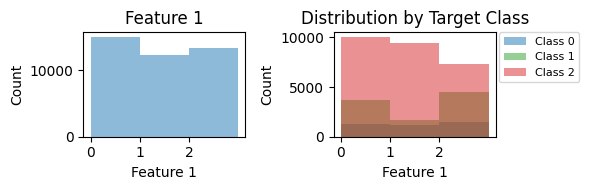

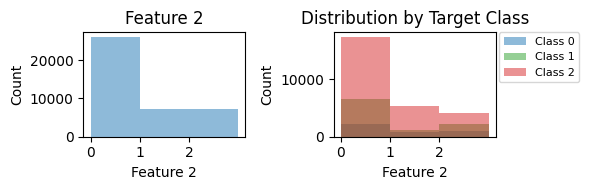

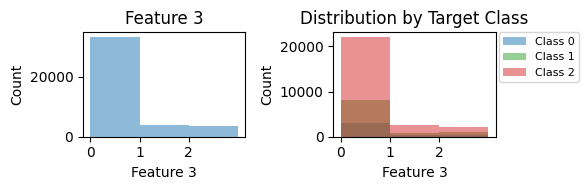

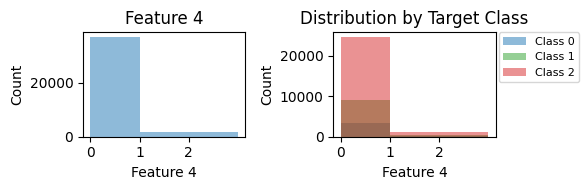

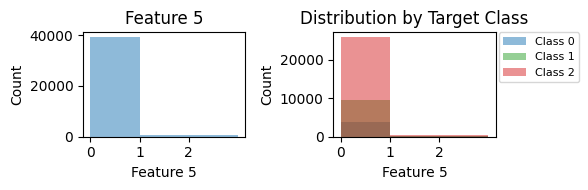

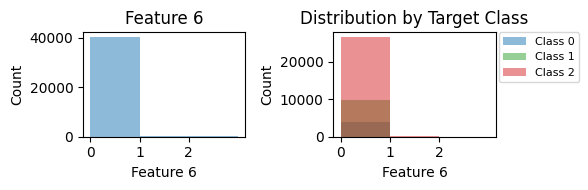

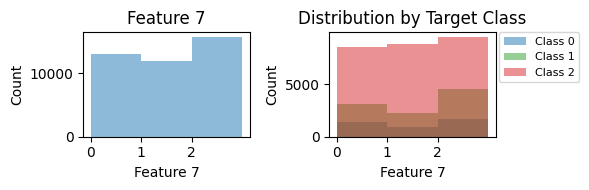

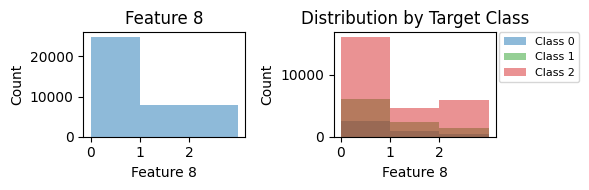

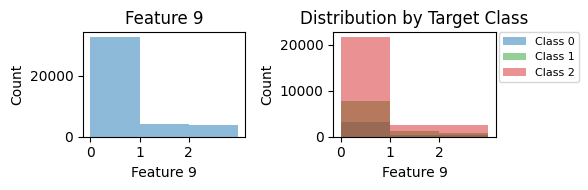

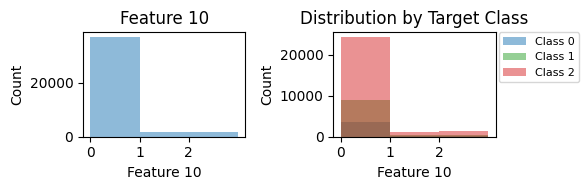

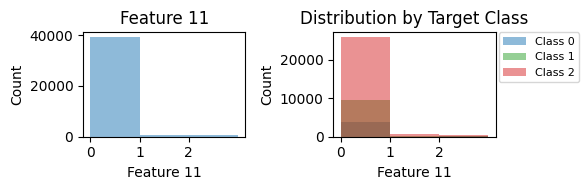

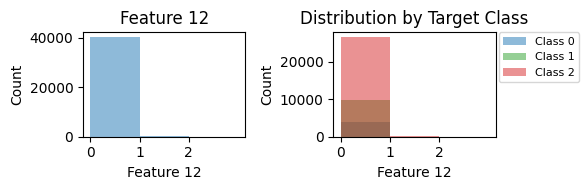

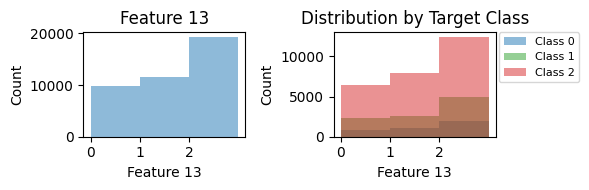

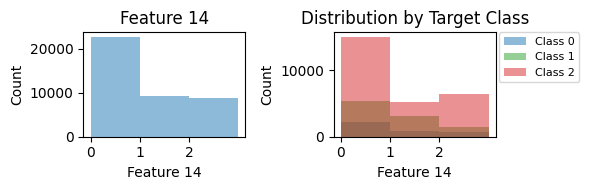

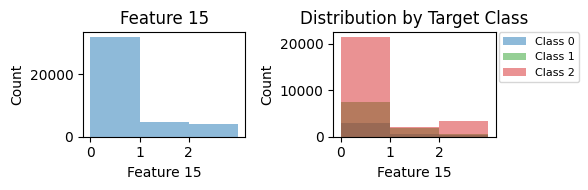

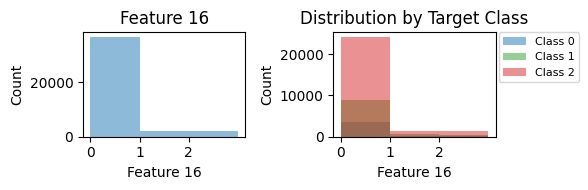

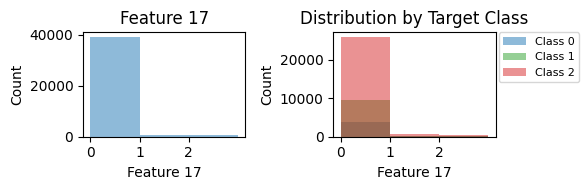

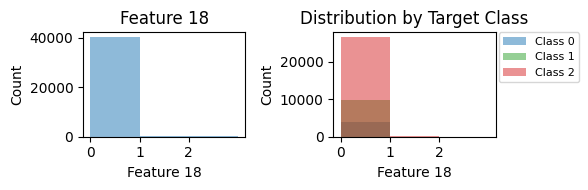

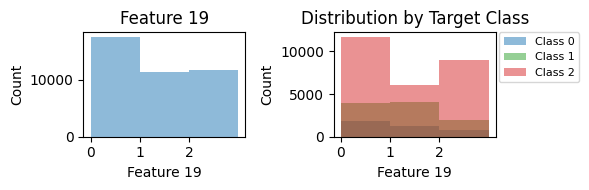

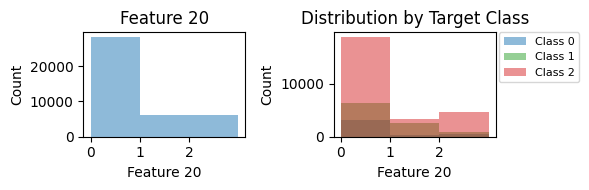

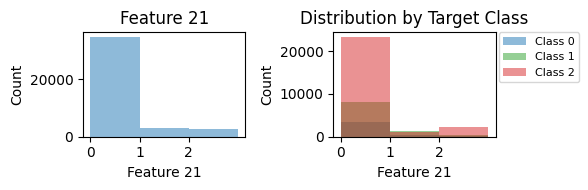

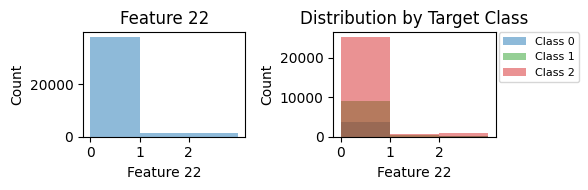

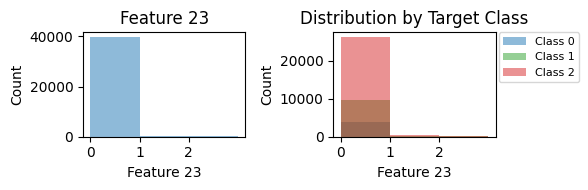

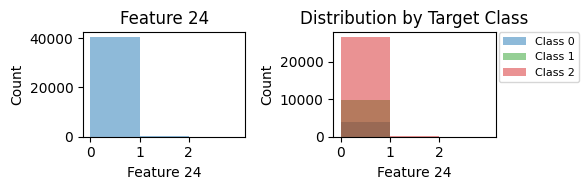

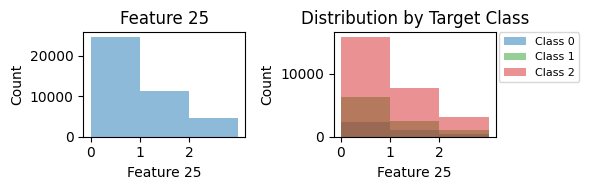

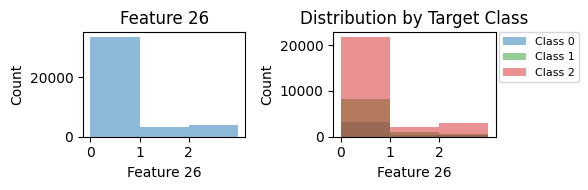

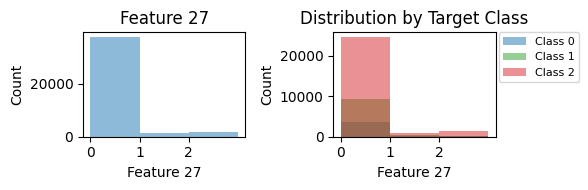

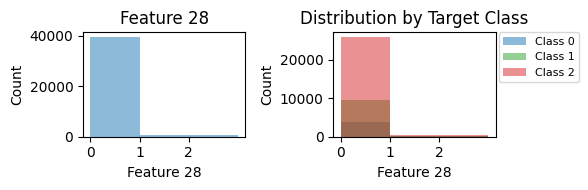

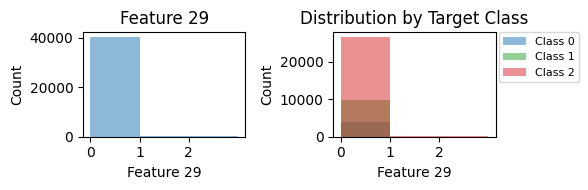

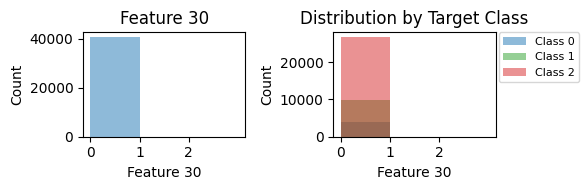

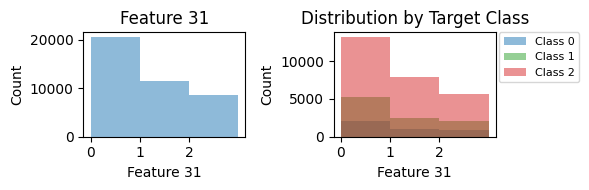

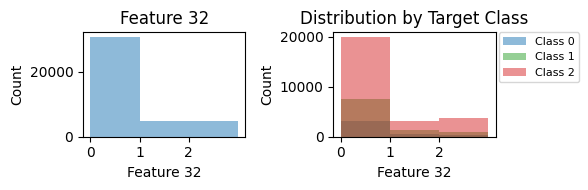

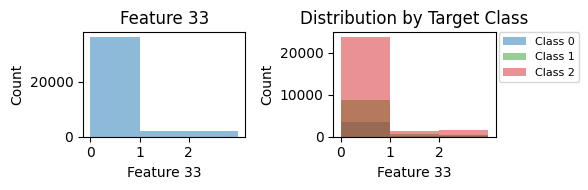

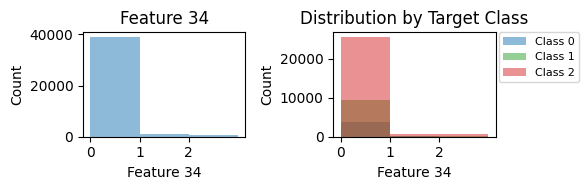

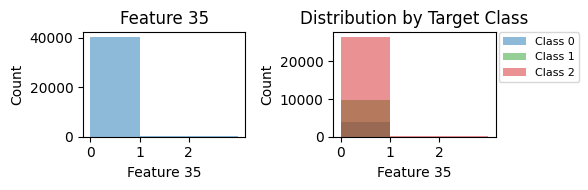

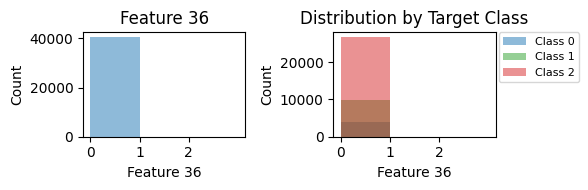

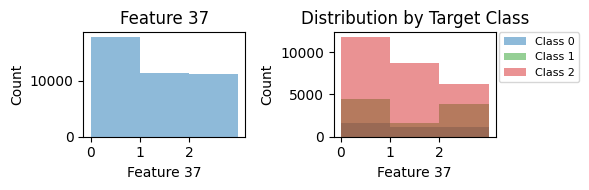

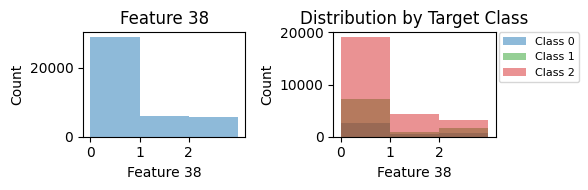

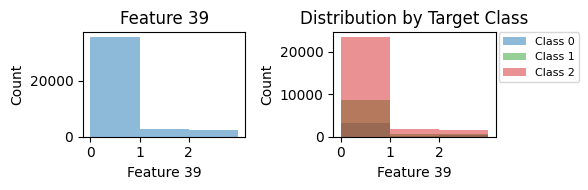

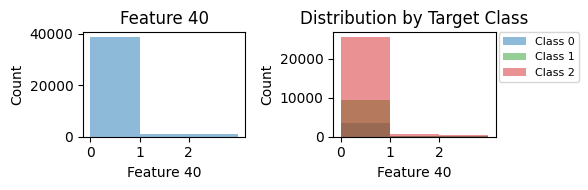

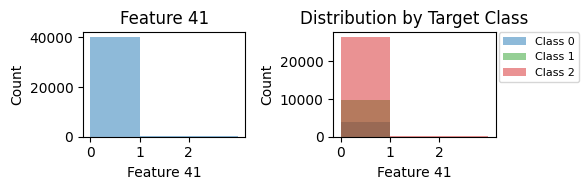

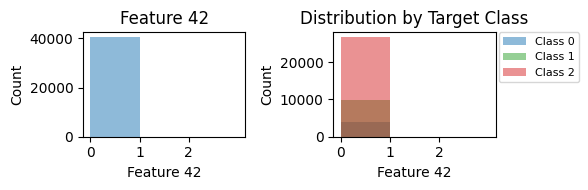

In [ ]:
# Histogram for each feature and its target distribution
for i in range(42):
    fig, axs = plt.subplots(1, 2, figsize=(6, 2))
    
    # Plot for the first histogram
    axs[0].hist(train_df.iloc[:, i], bins=[0, 1, 2, 3], color='tab:blue', alpha=0.5)
    axs[0].set_xticks([0, 1, 2])
    axs[0].set_xlabel(f'Feature {i+1}')
    axs[0].set_ylabel('Count')
    axs[0].set_title(f'Feature {i+1}')

    # Plot for the second histogram
    axs[1].hist(train_df[train_df['target']==0].iloc[:, i], bins=[0, 1, 2, 3], color='#1f77b4', alpha=0.5, label='Class 0')
    axs[1].hist(train_df[train_df['target']==1].iloc[:, i], bins=[0, 1, 2, 3], color='#2ca02c', alpha=0.5, label='Class 1')
    axs[1].hist(train_df[train_df['target']==2].iloc[:, i], bins=[0, 1, 2, 3], color='#d62728', alpha=0.5, label='Class 2')
    axs[1].set_xticks([0, 1, 2])
    axs[1].set_xlabel(f'Feature {i+1}')
    axs[1].set_ylabel('Count')
    axs[1].set_title(f'Distribution by Target Class')
    axs[1].legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0., prop={'size': 8})

    plt.tight_layout()
    plt.show()

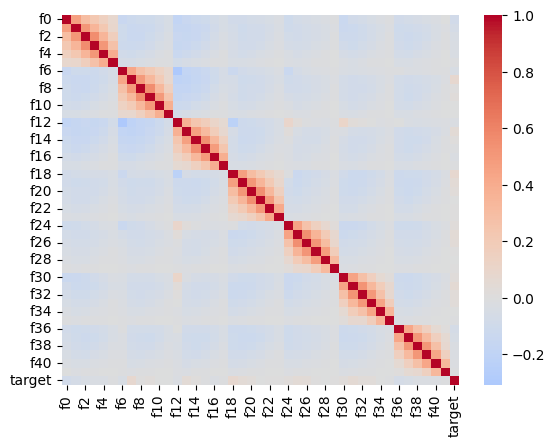

In [ ]:
corr = train_df.corr()
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.show()

trying different models and choosing the best one:

In [ ]:
# For training data
X_train = train_df.drop('target', axis=1)
y_train = train_df['target']

# For development/validation data
X_dev = dev_df.drop('target', axis=1)
y_dev = dev_df['target']

In [ ]:
# Check the class distribution in the 'target' column
class_distribution = train_df['target'].value_counts()
print(class_distribution)

2    26734
1     9882
0     3917
Name: target, dtype: int64


In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVC': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

balancing_techniques = {
    'No Balancing': None,
    'Random Over-sampling': RandomOverSampler(),
    'Random Under-sampling': RandomUnderSampler(),
    'SMOTE-ENN': SMOTEENN()
}

In [ ]:
# Iterate over balancing techniques
for technique_name, balancing_technique in balancing_techniques.items():
    print("###############################################")
    print(f'Balancing Technique: {technique_name}')
    
    # Apply balancing technique if it's not None
    if balancing_technique is not None:
        X_train_balanced, y_train_balanced = balancing_technique.fit_resample(X_train, y_train)
    else:
        X_train_balanced, y_train_balanced = X_train, y_train
    
    # Iterate over models
    for model_name, model in models.items():
        print(f'Model: {model_name}')
        
        # For LogisticRegression and SVC, set multi_class='ovr'
        if isinstance(model, (LogisticRegression, SVC)):
            model = OneVsRestClassifier(model)
        
        # Perform cross-validation
        cv_scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=StratifiedKFold(n_splits=5))
        print(f'Cross-Validation Accuracy: {cv_scores.mean()}')
        
        # Fit the model on the balanced training data
        model.fit(X_train_balanced, y_train_balanced)
        
        # Make predictions on the dev set
        y_pred = model.predict(X_dev)
        
        # Calculate and print performance metrics
        print('Confusion Matrix:')
        print(confusion_matrix(y_dev, y_pred))
        
        print('Classification Report:')
        print(classification_report(y_dev, y_pred))
        
        # Calculate AUC score
        y_dev_bin = label_binarize(y_dev, classes=model.classes_)
        y_pred_bin = label_binarize(y_pred, classes=model.classes_)
        auc_score = roc_auc_score(y_dev_bin, y_pred_bin, average='weighted')
        print(f'AUC Score: { auc_score }')
        
        print('--------------------------------------------')


###############################################
Balancing Technique: No Balancing
Model: Logistic Regression
Cross-Validation Accuracy: 0.6611156706755021
Confusion Matrix:
[[   0   26 1244]
 [   0  106 3267]
 [   0   69 8800]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1270
           1       0.53      0.03      0.06      3373
           2       0.66      0.99      0.79      8869

    accuracy                           0.66     13512
   macro avg       0.40      0.34      0.28     13512
weighted avg       0.57      0.66      0.54     13512

AUC Score: 0.509530067066696
--------------------------------------------
Model: SVC


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cross-Validation Accuracy: 0.7638960168540246
Confusion Matrix:
[[   0  292  978]
 [   0 1870 1503]
 [   0  308 8561]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1270
           1       0.76      0.55      0.64      3373
           2       0.78      0.97      0.86      8869

    accuracy                           0.77     13512
   macro avg       0.51      0.51      0.50     13512
weighted avg       0.70      0.77      0.72     13512

AUC Score: 0.7032348885915454
--------------------------------------------
Model: Random Forest


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cross-Validation Accuracy: 0.8006316515860178
Confusion Matrix:
[[ 154  351  765]
 [  90 2282 1001]
 [  60  308 8501]]
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.12      0.20      1270
           1       0.78      0.68      0.72      3373
           2       0.83      0.96      0.89      8869

    accuracy                           0.81     13512
   macro avg       0.70      0.59      0.60     13512
weighted avg       0.78      0.81      0.78     13512

AUC Score: 0.7711965123516527
--------------------------------------------
Model: Gradient Boosting
Cross-Validation Accuracy: 0.7518071716038547
Confusion Matrix:
[[  11  240 1019]
 [   1 1701 1671]
 [   3  374 8492]]
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.01      0.02      1270
           1       0.73      0.50      0.60      3373
           2       0.76      0.96      0.85      8869

    accuracy     

In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 10]
}

over_sample = RandomOverSampler()

# Create the RandomForestClassifier
model = RandomForestClassifier()

# Apply SMOTE-ENN to balance the training data
X_train_balanced, y_train_balanced = over_sample.fit_resample(X_train, y_train)

# Perform GridSearchCV for hyperparameter tuning on the balanced data
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train_balanced, y_train_balanced)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print('Best Parameters:')
print(best_params)

print('Best Model:')
print(best_model)

# Fit the best model on the balanced training data
best_model.fit(X_train_balanced, y_train_balanced)

# Make predictions on the development/validation data
y_pred = best_model.predict(X_dev)

# Evaluate the model's performance
print('Confusion Matrix:')
print(confusion_matrix(y_dev, y_pred))

print('Classification Report:')
print(classification_report(y_dev, y_pred))

# Calculate AUC score
y_dev_bin = label_binarize(y_dev, classes=best_model.classes_)
y_pred_bin = label_binarize(y_pred, classes=best_model.classes_)
auc_score = roc_auc_score(y_dev_bin, y_pred_bin, average='weighted')
print(f'AUC Score: {auc_score}')


Best Parameters:
{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Model:
RandomForestClassifier(max_features='log2', n_estimators=300)
Confusion Matrix:
[[ 283  385  602]
 [ 181 2496  696]
 [ 202  455 8212]]
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.22      0.29      1270
           1       0.75      0.74      0.74      3373
           2       0.86      0.93      0.89      8869

    accuracy                           0.81     13512
   macro avg       0.68      0.63      0.64     13512
weighted avg       0.79      0.81      0.80     13512

AUC Score: 0.8031526131654796


In [ ]:

cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
print("Standard Deviation of CV Scores:", cv_scores.std())

Cross-Validation Scores: [0.79782904 0.80152954 0.79647218 0.80088823 0.80372564]
Mean CV Score: 0.8000889259619163
Standard Deviation of CV Scores: 0.0026125787057441905


In [ ]:
X_test = test_df.drop('target', axis=1)
y_test = test_df['target']
y_pred_test = best_model.predict(X_test)

# Evaluate the model's performance on the test set
print('Confusion Matrix (Test Set):')
print(confusion_matrix(y_test, y_pred_test))

print('Classification Report (Test Set):')
print(classification_report(y_test, y_pred_test))

# Calculate AUC score for the test set
y_test_bin = label_binarize(y_test, classes=best_model.classes_)
y_pred_test_bin = label_binarize(y_pred_test, classes=best_model.classes_)
auc_score_test = roc_auc_score(y_test_bin, y_pred_test_bin, average='weighted')
print(f'AUC Score (Test Set): {auc_score_test}')


Confusion Matrix (Test Set):
[[ 284  358  620]
 [ 189 2449  742]
 [ 191  472 8207]]
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.43      0.23      0.29      1262
           1       0.75      0.72      0.74      3380
           2       0.86      0.93      0.89      8870

    accuracy                           0.81     13512
   macro avg       0.68      0.62      0.64     13512
weighted avg       0.79      0.81      0.80     13512

AUC Score (Test Set): 0.796826452269951


In [ ]:


# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [1, 10],
    'kernel': ['linear', 'rbf']
}                                                                                                      

over_sample = RandomOverSampler()

# Apply SMOTE-ENN to balance the training data
X_train_balanced, y_train_balanced = over_sample.fit_resample(X_train, y_train)

# Create the SVC model
model = SVC()

# Perform GridSearchCV for hyperparameter tuning on the balanced data
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train_balanced, y_train_balanced)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model_svc = grid_search.best_estimator_
print('Best Parameters:')
print(best_params)

print('Best Model:')
print(best_model_svc)

# Fit the best model on the balanced training data
best_model_svc.fit(X_train_balanced, y_train_balanced)

# Make predictions on the development/validation data
y_pred = best_model_svc.predict(X_dev)

# Evaluate the model's performance
print('Confusion Matrix:')
print(confusion_matrix(y_dev, y_pred))

print('Classification Report:')
print(classification_report(y_dev, y_pred))

# Calculate AUC score
y_dev_bin = label_binarize(y_dev, classes=best_model_svc.classes_)
y_pred_bin = label_binarize(y_pred, classes=best_model_svc.classes_)
auc_score = roc_auc_score(y_dev_bin, y_pred_bin, average='weighted')
print(f'AUC Score: {auc_score}')


In [ ]:
# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
print("Standard Deviation of CV Scores:", cv_scores.std())

# Make predictions on the test set
y_pred_test = best_model_svc.predict(X_test)

# Evaluate the model's perf ormance on the test set
print('Confusion Matrix (Test Set):')
print(confusion_matrix(y_test, y_pred_test))

print('Classification Report (Test Set):')
print(classification_report(y_test, y_pred_test))

# Calculate AUC score for the test set
y_test_bin = label_binarize(y_test, classes=best_model_svc.classes_)
y_pred_test_bin = label_binarize(y_pred_test, classes=best_model_svc.classes_)
auc_score_test = roc_auc_score(y_test_bin, y_pred_test_bin, average='weighted')
print(f'AUC Score (Test Set): {auc_score_test}')

1. Method of choosing the best model:

for each balanced version of the data, the code trains and evaluates a range of machine learning models. (logistic regression, Support Vector Classification, Randim Forest and Gradient Boosting)

The performance of each model is assessed using cross-validation. This involves splitting the training data into several parts , training the model on some of these parts and testing it on the remaining part. This is repeated multiple times with different parts used for testing each time. This provides a robust assessment of the model's performance that is less likely to be biased by the particular way the data is split into training and testing sets.

Then we evaluates each model's performance using several metrics, including a confusion matrix, a classification report, and an AUC score. The confusion matrix and classification report provide detailed information on how well the model is predicting each class. The AUC score provides a single summary measure of the model's performance, with higher scores indicating better performance.

By comparing these metrics across different models and balancing techniques, we can determine which combination performs best on this data.

To address class imbalance in the dataset, SMOTE-ENN and RandomOverSampling balancing techniques are employed. The choice of these techniques and how they handle the balancing can be explained as follows:

SMOTE-ENN: SMOTE (Synthetic Minority Over-sampling Technique) is used to oversample the minority class by generating synthetic samples. It works by interpolating new instances between existing minority class samples. ENN (Edited Nearest Neighbors) is then applied to remove noisy samples from the majority class. SMOTE-ENN combines both techniques to create a balanced dataset with reduced noise. This method was chosen as it effectively addresses class imbalance by generating synthetic samples while simultaneously removing potential outliers or noisy data points.

RandomOverSampling: RandomOverSampling increases the number of instances in the minority class by randomly duplicating existing samples. This approach is simple yet effective in alleviating class imbalance. It was chosen as an alternative balancing method to compare its performance against SMOTE-ENN.

To determine the best balancing method for the final model, we performed grid search with cross-validation. The grid search evaluates multiple combinations of hyperparameters and balancing techniques. The performance of each combination is assessed using the evaluation metric(s) on the dev set. The results of the grid search provide insights into which combination of hyperparameters and balancing techniques achieve the highest accuracy or other desired metrics.

Based on the evaluation results, the best balancing method can be chosen by comparing the performance of SMOTE-ENN and RandomOverSampling. The method that yields the highest accuracy or best overall performance on the dev set was considered the optimal choice.

2. Description of the the hyperparameter search and how each hyperparameter affects the model’s accuracy.

The hyperparameter search in the provided code involves grid search, which systematically explores all possible combinations of hyperparameters to find the best configuration. The hyperparameters that are being tuned for each model include:
max_depth: The maximum depth of the decision trees. A higher max_depth allows the trees to grow deeper and capture more complex relationships in the data. However, if set too high, it can lead to overfitting, as the trees may memorize the training data. By finding the optimal max_depth through grid search, we can strike a balance between model complexity and generalization.

n_estimators: The number of decision trees in the random forest. Increasing n_estimators can improve the model's performance up to a certain point, as more trees allow for a more robust decision-making process. However, adding too many trees can lead to diminishing returns or increased computational cost. The grid search helps us find the optimal number of estimators that maximizes performance.

learning_rate: The step size shrinkage used in gradient boosting. A lower learning rate can make the model more robust and help prevent overfitting. It controls how much each tree contributes to the overall prediction. By searching for the best learning rate, we can find the optimal balance between model accuracy and convergence speed.

C: The inverse of regularization strength in logistic regression. Smaller values of C increase the regularization strength, which can prevent overfitting by discouraging complex decision boundaries. On the other hand, larger values of C allow the model to fit the training data more closely. By tuning C, we can find the right level of regularization that maximizes the model's accuracy.

kernel: The type of kernel used in support vector machines (SVMs). The choice of kernel affects the decision boundary and the model's ability to capture complex patterns. Different kernel functions have different properties, such as linear, polynomial, or radial basis function (RBF). By exploring different kernel options, we can find the one that best suits the underlying data distribution.